##### importing data

In [27]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 
#!pip install lifelines
import seaborn as sns
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats
from matplotlib.patches import Patch


In [28]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
df_anyue = pd.read_excel("Individual parameters_START_TKI patients_AYin.xlsx")
df_anyue = df_anyue[["PID","PD_Kg(/day)","PD_Kd(/day)","PD_Km(/day)"]]
df_anyue = df_anyue.rename(columns={"PID": "ID", "PD_Kg(/day)": "kg", "PD_Kd(/day)": "kd", "PD_Km(/day)": "km"})
df_anyue = df_anyue.loc[~df_anyue['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
cols = df_anyue.columns.tolist()
cols[2],cols[3]=cols[3],cols[2] # swap kd and km so anyue's columns match ours
df_anyue = df_anyue[cols]

##### logistic model

In [149]:
# Logistic population model
def system_ode_logistic(time, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    kd = params[2] #death rate due to medication

    dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax) - kd)
    dRpop_dt = Rpop * (r * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function
def cost_func_logistic(params, time, data):
    initial_populations = params[3:]
    #initial_populations = [params[3], data[0]-params[3]]
    tspan = [time[0], time[-1]]
    
    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(time), args = tuple([params[:3]]))
    
    if pred_data_log.y.shape[1] == np.ravel(time).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        rmse = np.sqrt(msq_error)
        # pseudo huber loss
        delta = 100
        huber_loss = np.sum(np.where(np.abs(sum_pops - data) < delta, 0.5*(sum_pops - data)**2, delta*(np.abs(sum_pops - data) - 0.5*delta)))/len(data)
    else: 
        msq_error = 1e30
        rmse = 1e30
        mean_abs_error = 1e30
        huber_loss = 1e30

    #return mean_abs_error
    #return msq_error
    return rmse
    #return huber_loss
   


##### logistic DE

In [169]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    max_value = max(data[0], data[-1])

    print("Working on patient:", id, " Number of data points:", len(days))
    bounds = [(1e-3, 5e-1), (1.1*max_value, 1.5*max_value), (1e-2, 1e-1),(0.8*data[0], data[0]-1e-2),(1e-2,0.2*data[0])] # r, K, kd, spop0, 
    bounds = [(1e-3, 5e-1), (1.1*max_value, 1.5*max_value), (5e-3, 2e-1),(0.8*data[0], data[0]-1e-2),(1e-2,0.2*data[0])] # r, K, kd, spop0, 
    bounds = [(5e-4, 5e-1), (1.1*max_value, 1.5*max_value), (5e-3, 2e-1),(0.8*data[0], data[0]-1e-2),(1e-2,0.2*data[0])] # r, K, kd, spop0, 
    bounds = [(1e-4, 5e-1), (1.1*max_value, 2*max_value), (5e-3, 2e-1),(0.8*data[0], data[0]-1e-2),(1e-2,0.2*data[0])] # r, K, kd, spop0, 
    bounds = [(1e-4, 5e-1), (1.1*max_value, 2*max_value), (5e-3, 1e-1),(0.8*data[0], data[0]-1e-2),(1e-2,0.2*data[0])] # r, K, kd, spop0,

    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_logistic, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


In [173]:
df_log = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0','error'])
df_log

df_log.to_csv('log_params_start_TKI.csv', index=False)

In [170]:
df_log2 = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','rpop_0','error'])
df_log2-df_log  # negative error means this is better 

,r,Kmax,kd,spop_0,rpop_0,error
A1002,0.000023,-459.083838,-0.000250,-71.974647,0.000000,0.336744
A1004,0.000000,-4.950117,0.000002,0.068312,0.023699,-0.000321
A1006,0.000000,12259.619367,0.000049,-20.750028,2.874174,-0.105770
A1007,0.000052,-219.559422,-0.000018,10.002623,0.299124,-0.769636
A1008,-0.000022,2240.466708,0.000035,-3.567498,-2.072833,-0.342596
A1009,-0.000655,1210.022421,0.000378,-79.453295,65.102583,1.437519
A1011,0.000000,475.615741,-0.000072,-1.131412,-3.167190,-0.013083
A1012,-0.000439,12068.521194,0.000375,-45.857518,4.716043,1.738680
A1013,0.000000,1177.187435,-0.000034,-16.888010,-0.917221,0.116690
A1014,0.000047,0.933217,0.000133,1.846797,-0.029173,-0.005264


##### plotting 

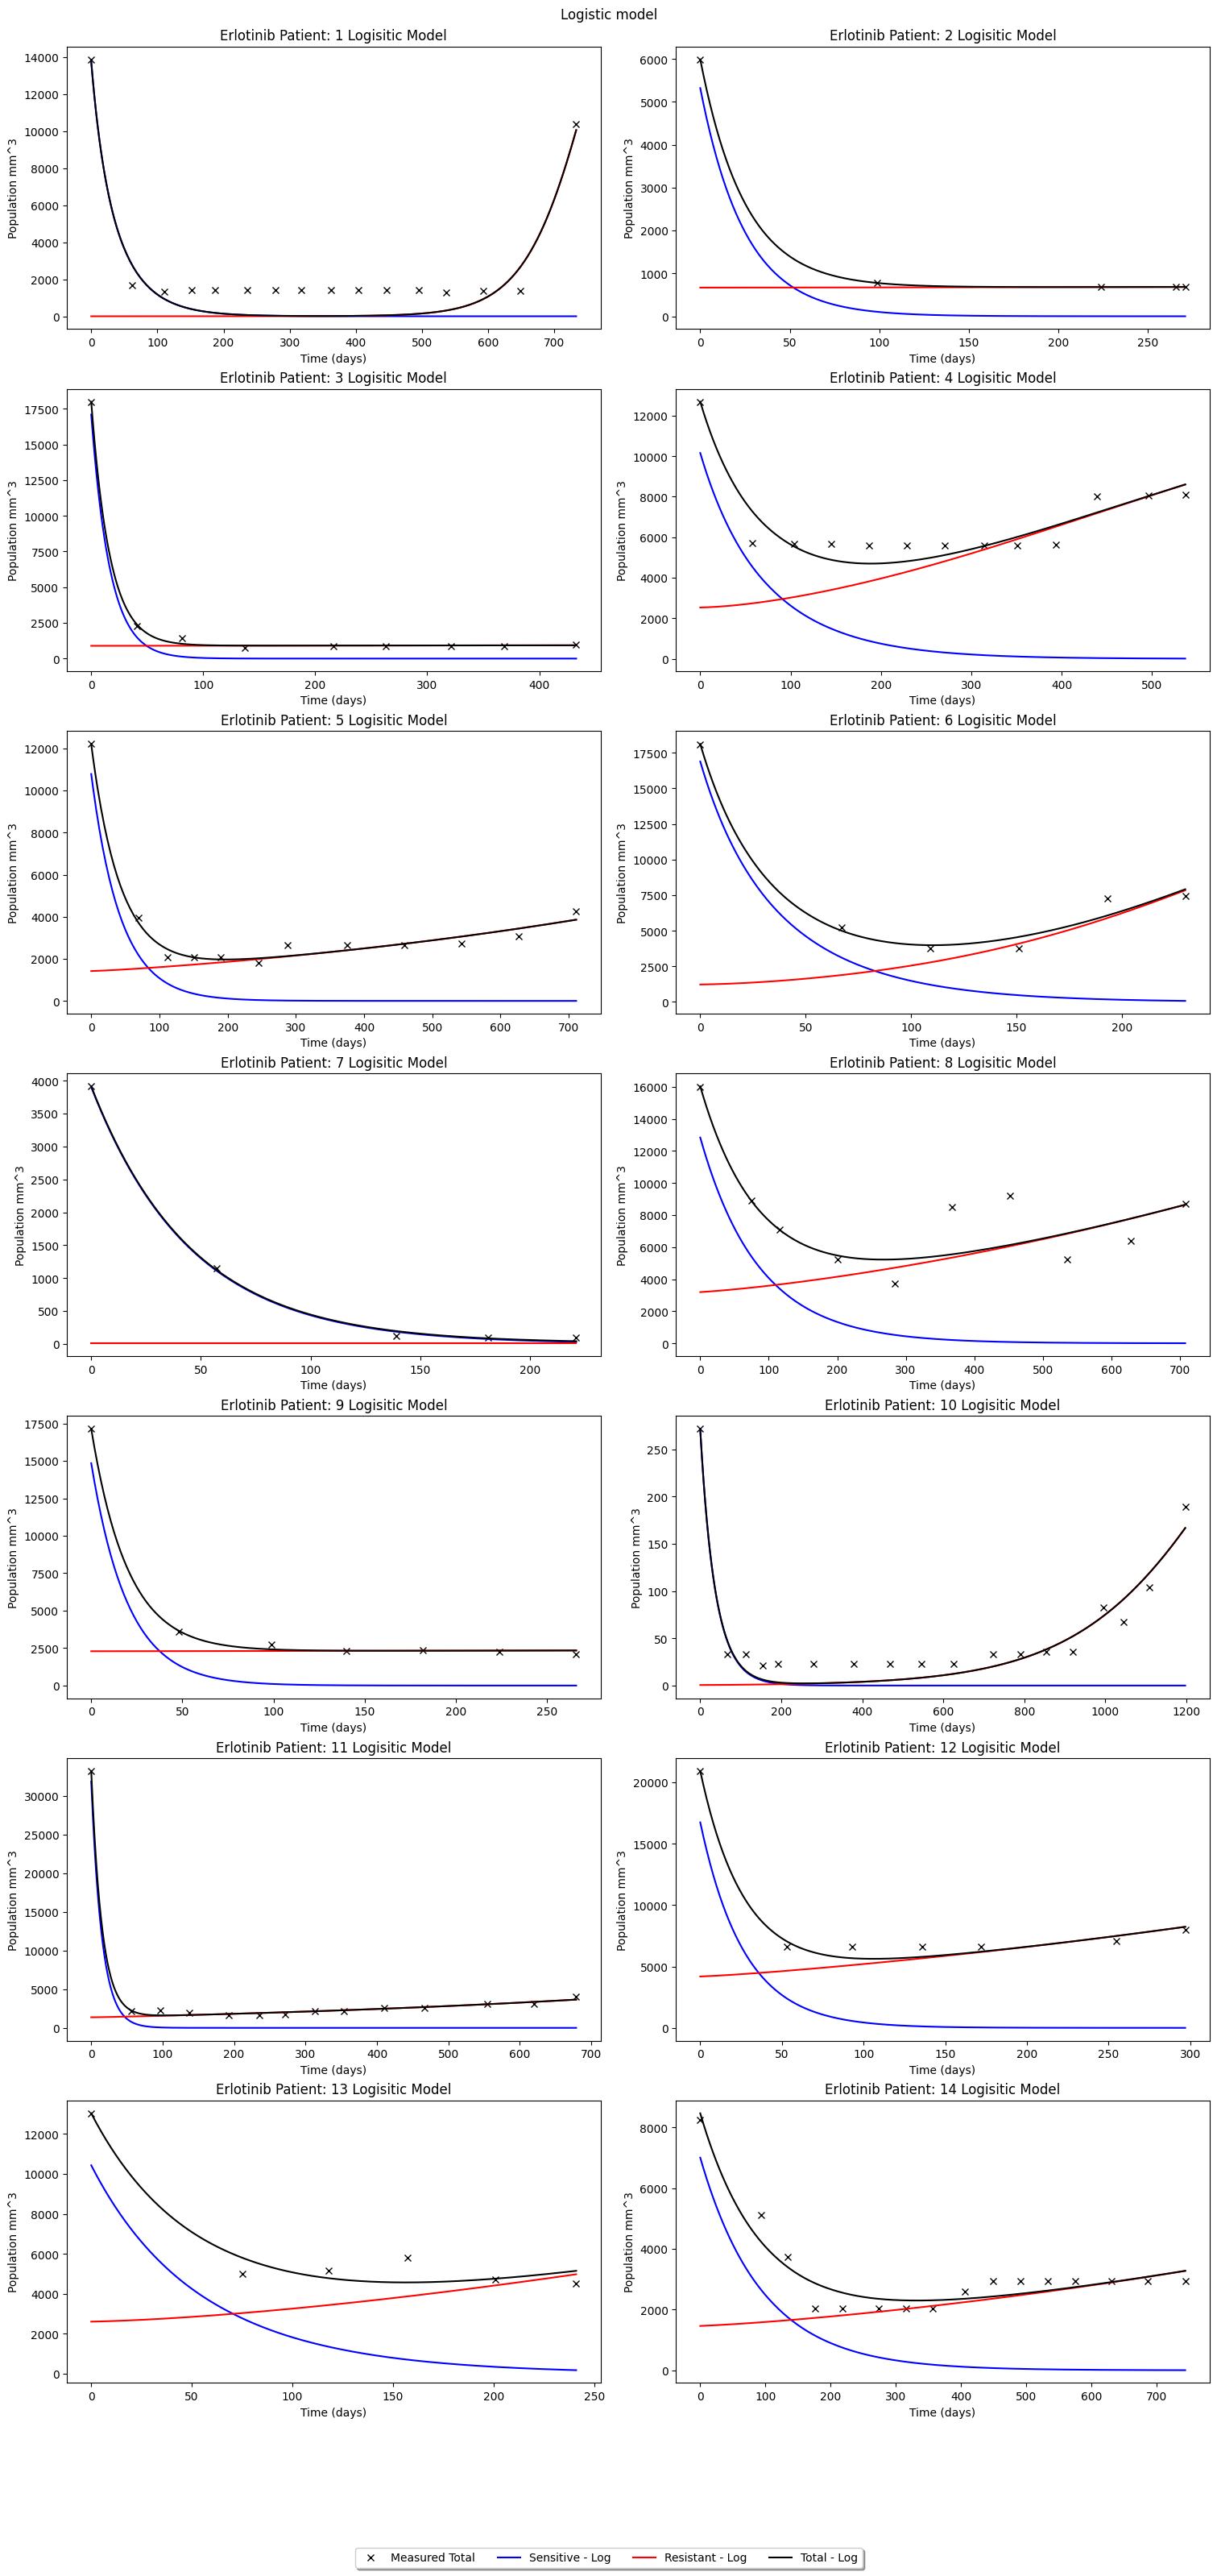

In [171]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = optimal_params_log[3:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index +1} Logisitic Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### 1/2 dose

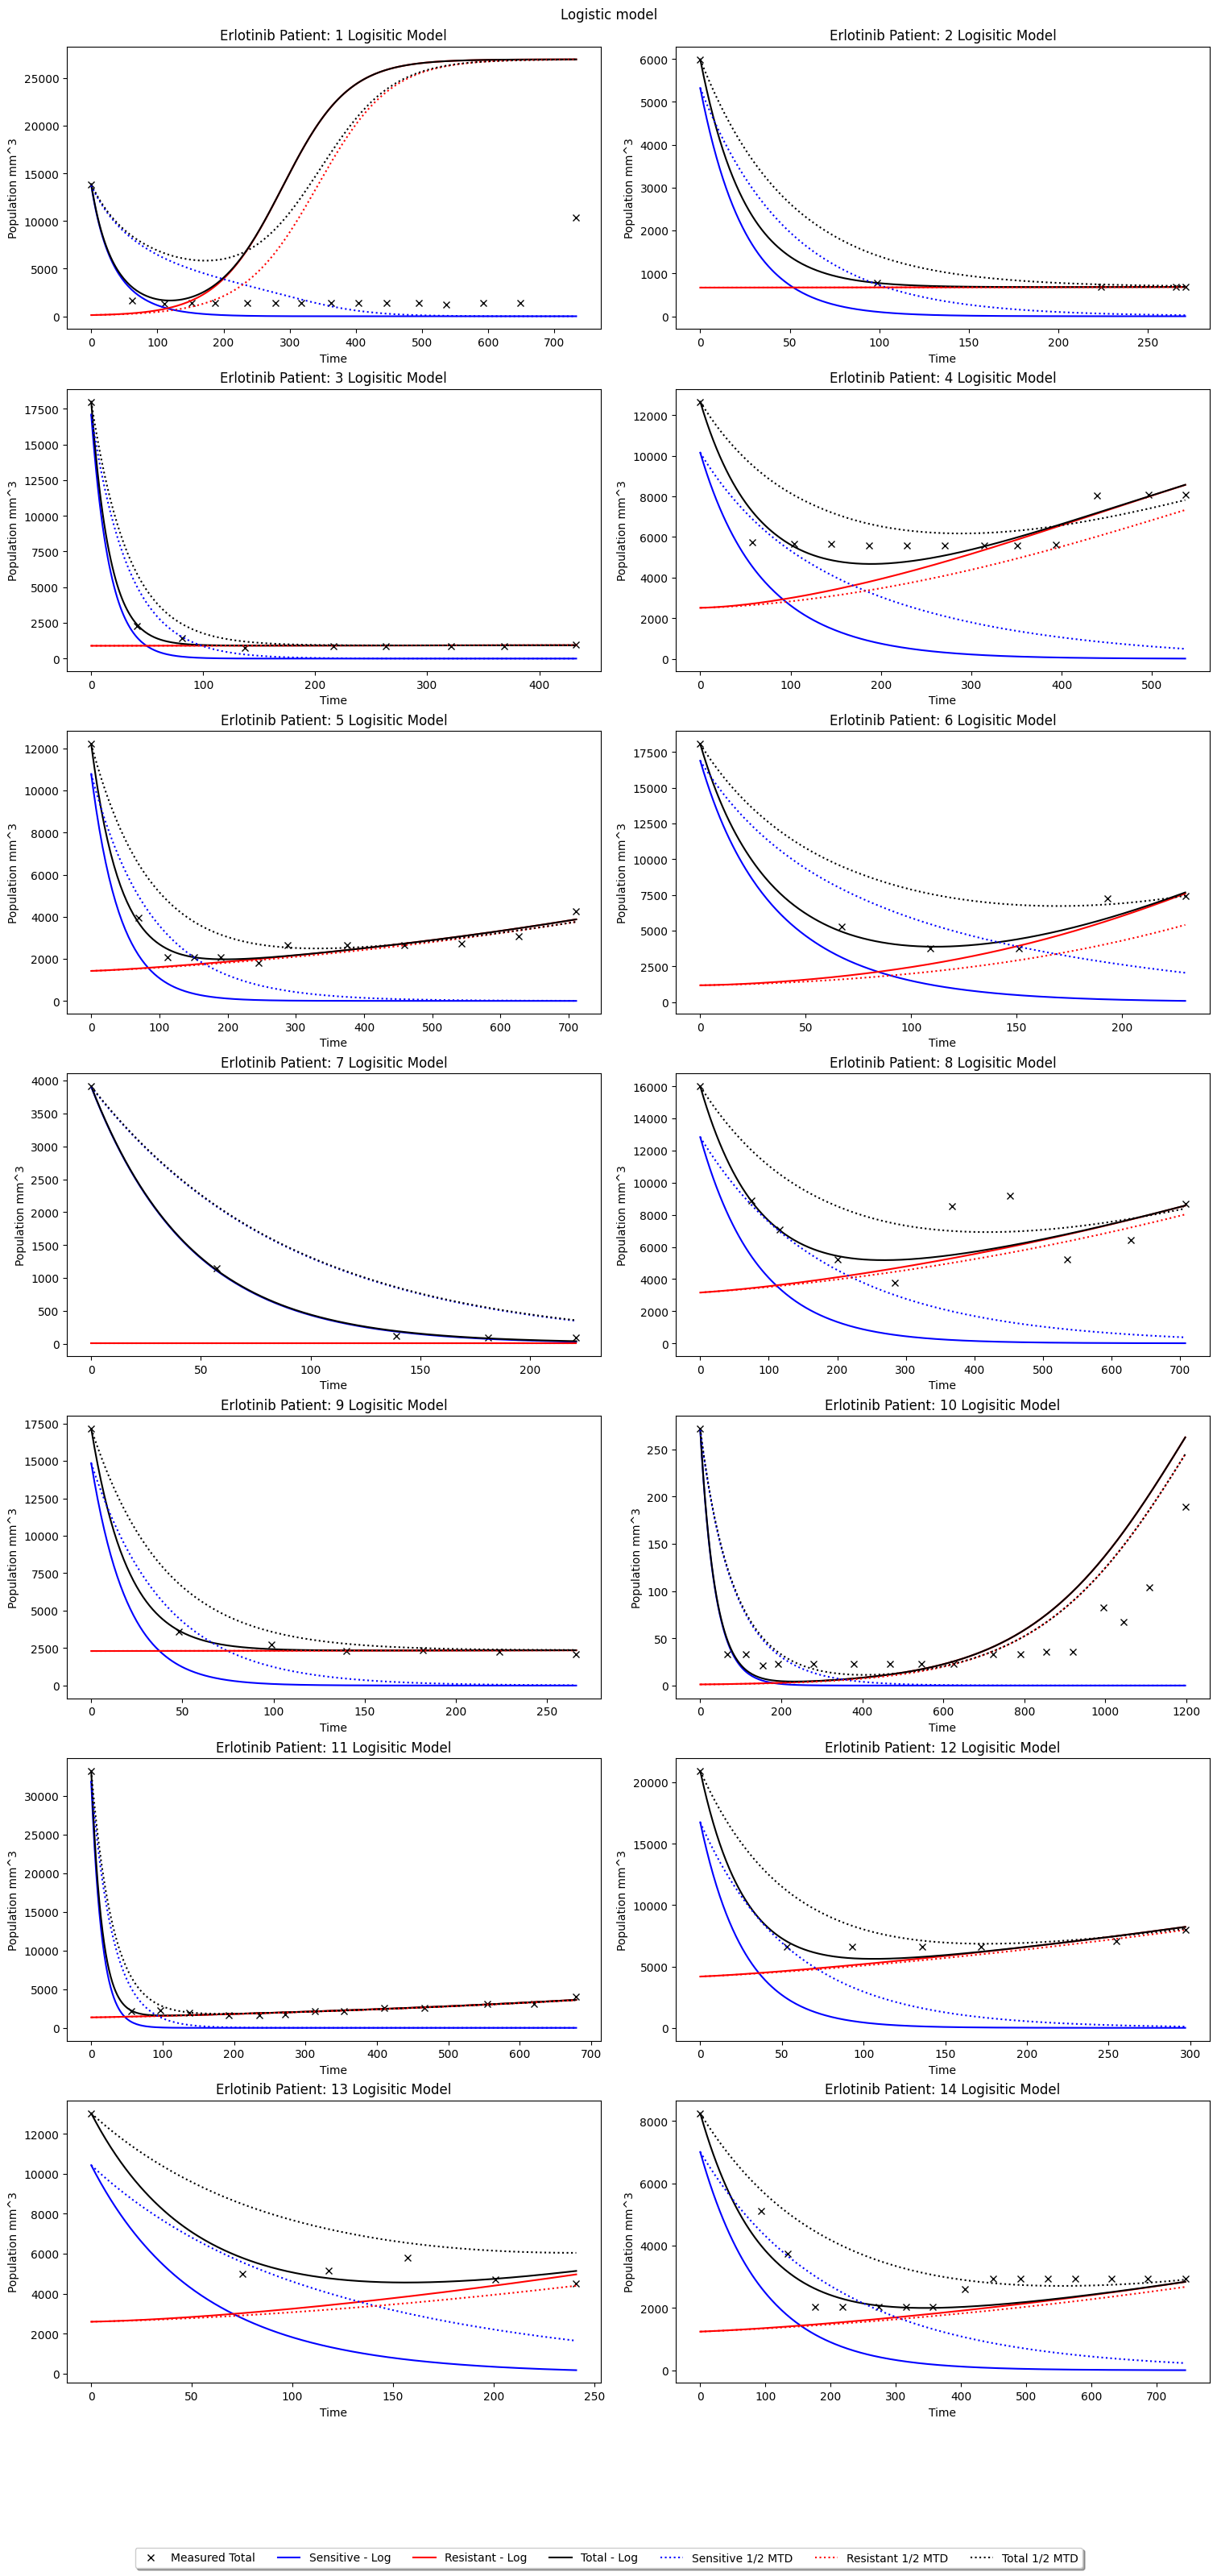

In [174]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15,30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3], data[0]-optimal_params_log[3]]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

# half dose
    optimal_params_half = master_dictionary_copy[id]
    init_populations_half = [optimal_params_half[3], data[0]-optimal_params_half[3]]

    pred_data_half = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_half, dense_output=True,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)


#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')

     # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index+1} Logisitic Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),
                    Line2D([0], [0], color='b', linestyle=':', label='Sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle=':', label='Resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total 1/2 MTD'),
                   ]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### extending time

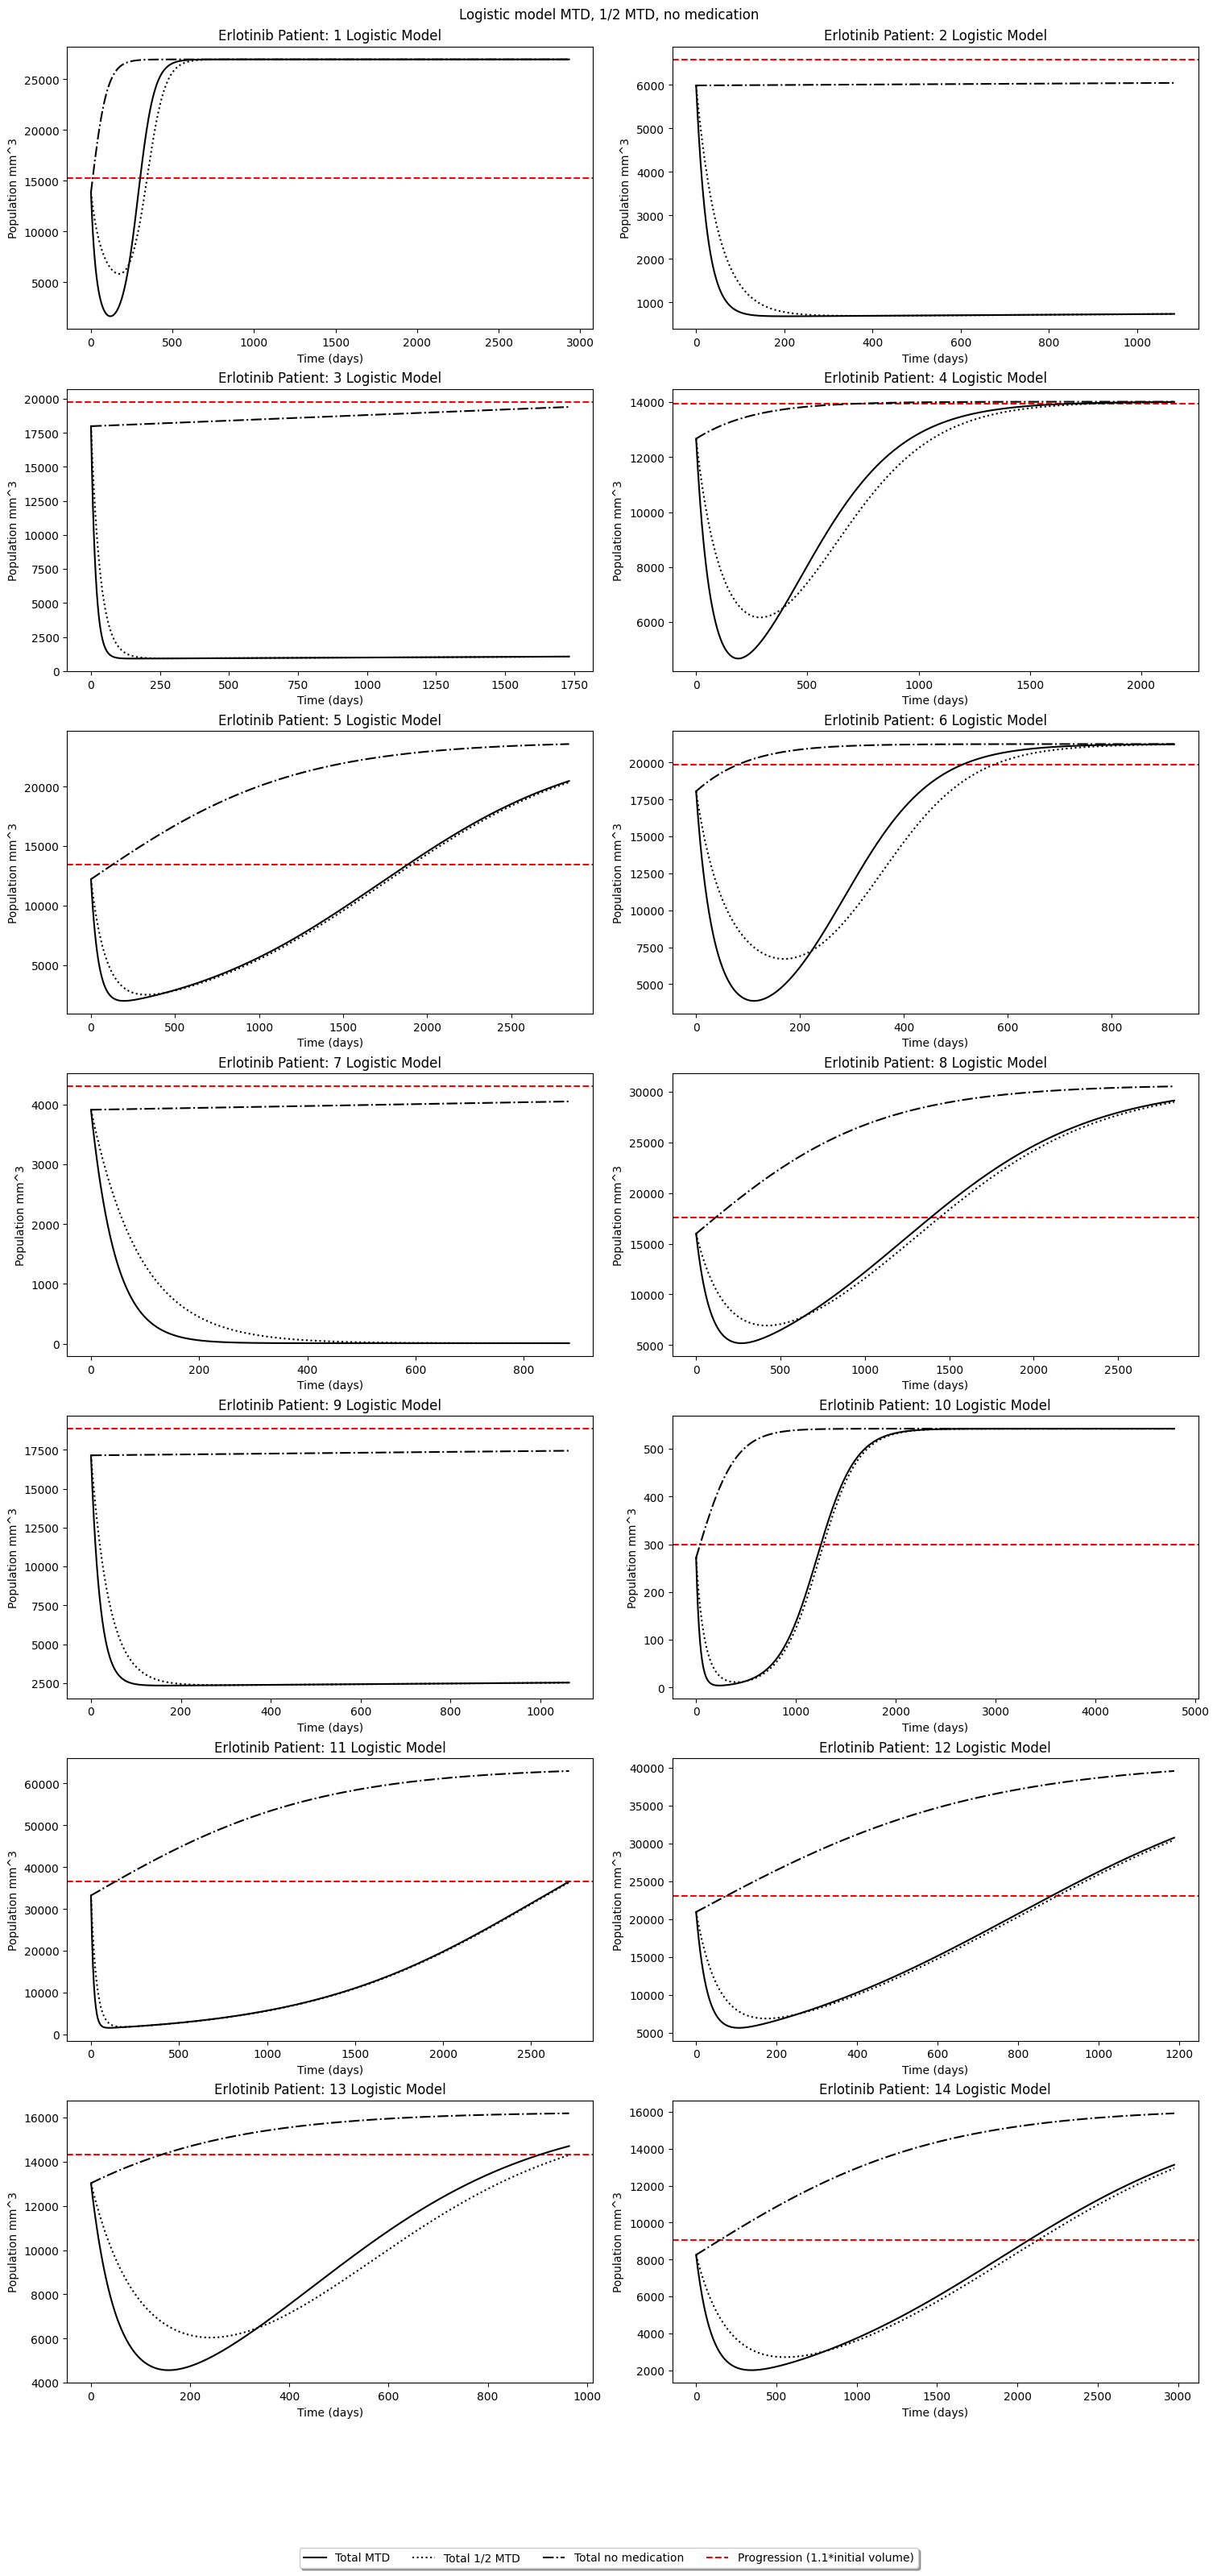

In [176]:
progression_list = []
progression_half_list = []
progression_02_list = []
progression_list_0 = []
comp_release_list = []
comp_release_half_list = []
comp_release_02_list = []
comp_release_list_0 = []

sim_time_factor = 4

# Store changed medication parameters
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

master_dictionary_copy2 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy2:
    master_dictionary_copy2[key][2] *= 0.2 # simulate dose of 0.2 MTD

master_dictionary_copy0 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy0:
    master_dictionary_copy0[key][2] *= 0 # simulate dose of 0

# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15,30), constrained_layout=True)

# fitting data for parameters with 0, 0.2, 0.5, 1 * MTD
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()

    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

### optimal params MTD
    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3],data[0]-optimal_params_log[3]]
    pred_data_log = solve_ivp(system_ode_logistic, [0,sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

### optimal params + 0.5 MTD
    optimal_params_log_half = master_dictionary_copy[id] 
    init_populations_log_half = [optimal_params_log_half[3],data[0]-optimal_params_log_half[3]]

    pred_data_log_half = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_half, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_half[:3]]))
    sum_pops_log_half = np.sum(pred_data_log_half.sol(tspan), axis=0)

### optimal params + 0.2 medication
    optimal_params_2 = master_dictionary_copy2[id] 
    init_populations_2 = [optimal_params_2[3],data[0]-optimal_params_2[3]]
    pred_data_2 = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_2, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_2[:3]]))
    sum_pops_2 = np.sum(pred_data_2.sol(tspan), axis=0)

### optimal params + 0 medication
    optimal_params_0 = master_dictionary_copy0[id] 
    init_populations_0 = [optimal_params_0[3],data[0]-optimal_params_0[3]]
    pred_data_0 = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_0, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_0[:3]]))
    sum_pops_0 = np.sum(pred_data_0.sol(tspan), axis=0)


    # Find progression for logistic MTD
    progression_mtd = np.argmin(np.abs(sum_pops_log - 1.1*data[0]))
    x_value_progression = tspan[progression_mtd]

    # Find progression for logistic half MTD
    progression_half_mtd = np.argmin(np.abs(sum_pops_log_half - 1.1*data[0]))
    x_value_progression_half = tspan[progression_half_mtd]

    # Find progression for logistic 0.2 MTD
    progression_02_mtd = np.argmin(np.abs(sum_pops_2 - 1.1*data[0]))
    x_value_progression_02 = tspan[progression_02_mtd]

    # Find progression for logistic 0 MTD
    progression_0_mtd = np.argmin(np.abs(sum_pops_0 - 1.1*data[0]))
    x_value_progression_0 = tspan[progression_0_mtd]


    # Append the id and x_value_progression to the list
    progression_list.append((id, x_value_progression))
    progression_half_list.append((id, x_value_progression_half))
    progression_02_list.append((id, x_value_progression_02))
    progression_list_0.append((id, x_value_progression_0))
    


#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    #ax.plot(days, data, 'kx', label='Measured Total') 
    ax.axhline(y=1.1*data[0], color='r', linestyle='--') ### line to show progression

    # plot with full medication
    #ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    #ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')

    # plot with half medication
    #ax.plot(tspan, pred_data_log_half.sol(tspan)[0], 'b:', label='Sensitive - Log') 
    #ax.plot(tspan, pred_data_log_half.sol(tspan)[1], 'r:', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log_half, 'k:', label='Total - Log')

    # plot with 0.2 medication
    #ax.plot(tspan, pred_data_2.sol(tspan)[0], 'b:', label='Sensitive - Log')
    #ax.plot(tspan, pred_data_2.sol(tspan)[1], 'r:', label='Resistant - Log')
    #ax.plot(tspan, sum_pops_2, 'k--', label='Total - Log')

    # plot with 0 medication
    #ax.plot(tspan, pred_data_0.sol(tspan)[0], 'b:', label='Sensitive - Log')
    #ax.plot(tspan, pred_data_0.sol(tspan)[1], 'r:', label='Resistant - Log')
    ax.plot(tspan, sum_pops_0, 'k-.', label='Total - Log') 

    #set axis labels
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index + 1} Logistic Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [
    #Line2D([0], [0], marker='x', color='k', label='Measurement', linestyle='None'),
    #Line2D([0], [0], color='b', label='Sensitive '),
    #Line2D([0], [0], color='r', label='Resistant'),
    Line2D([0], [0], color='k', label='Total MTD'),
    #Line2D([0], [0], color='b', linestyle=':', label='Sensitive 1/2 MTD'),
    #Line2D([0], [0], color='r', linestyle=':', label='Resistant 1/2 MTD'),
    Line2D([0], [0], color='k', linestyle=':', label='Total 1/2 MTD'),
    #Line2D([0], [0], color='k', linestyle='--', label='Total 0.2*MTD'),
    Line2D([0], [0], color='k', linestyle='-.', label='Total no medication'),
    Line2D([0], [0], color='r', linestyle='--', label='Progression (1.1*initial volume)')
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model MTD, 1/2 MTD, no medication')  
plt.show()

##### Zhang

Switch points for patient 1: [(0.0, 14.6648882960987)]
Switch points for patient 2: [(0.0, 21.325775258419473)]
Switch points for patient 3: [(0.0, 12.705568522840949)]
Switch points for patient 4: [(0.0, 108.86828942980995), (692.6028676225409, 2148.0)]
Switch points for patient 5: [(0.0, 38.8809603201067), (985.3004334778259, 1038.4061353784593), (1980.0840280093364, 2844.0)]
Switch points for patient 6: [(0.0, 32.2107369123041), (153.07769256418806, 190.5035011670557), (311.06368789596536, 920.0)]
Switch points for patient 7: [(0.0, 32.424141380460156)]
Switch points for patient 8: [(0.0, 93.48716238746248), (655.3544514838279, 2832.0)]
Switch points for patient 9: [(0.0, 17.384461487162387)]
Switch points for patient 10: [(0.0, 20.754918306102034), (440.6428809603201, 464.59086362120706), (895.6545515171724, 919.6025341780594), (1334.7009003001, 1361.841947315772), (1775.3437812604202, 1815.2570856952318), (2222.37279093031, 4788.0)]
Switch points for patient 11: [(0.0, 11.77325775

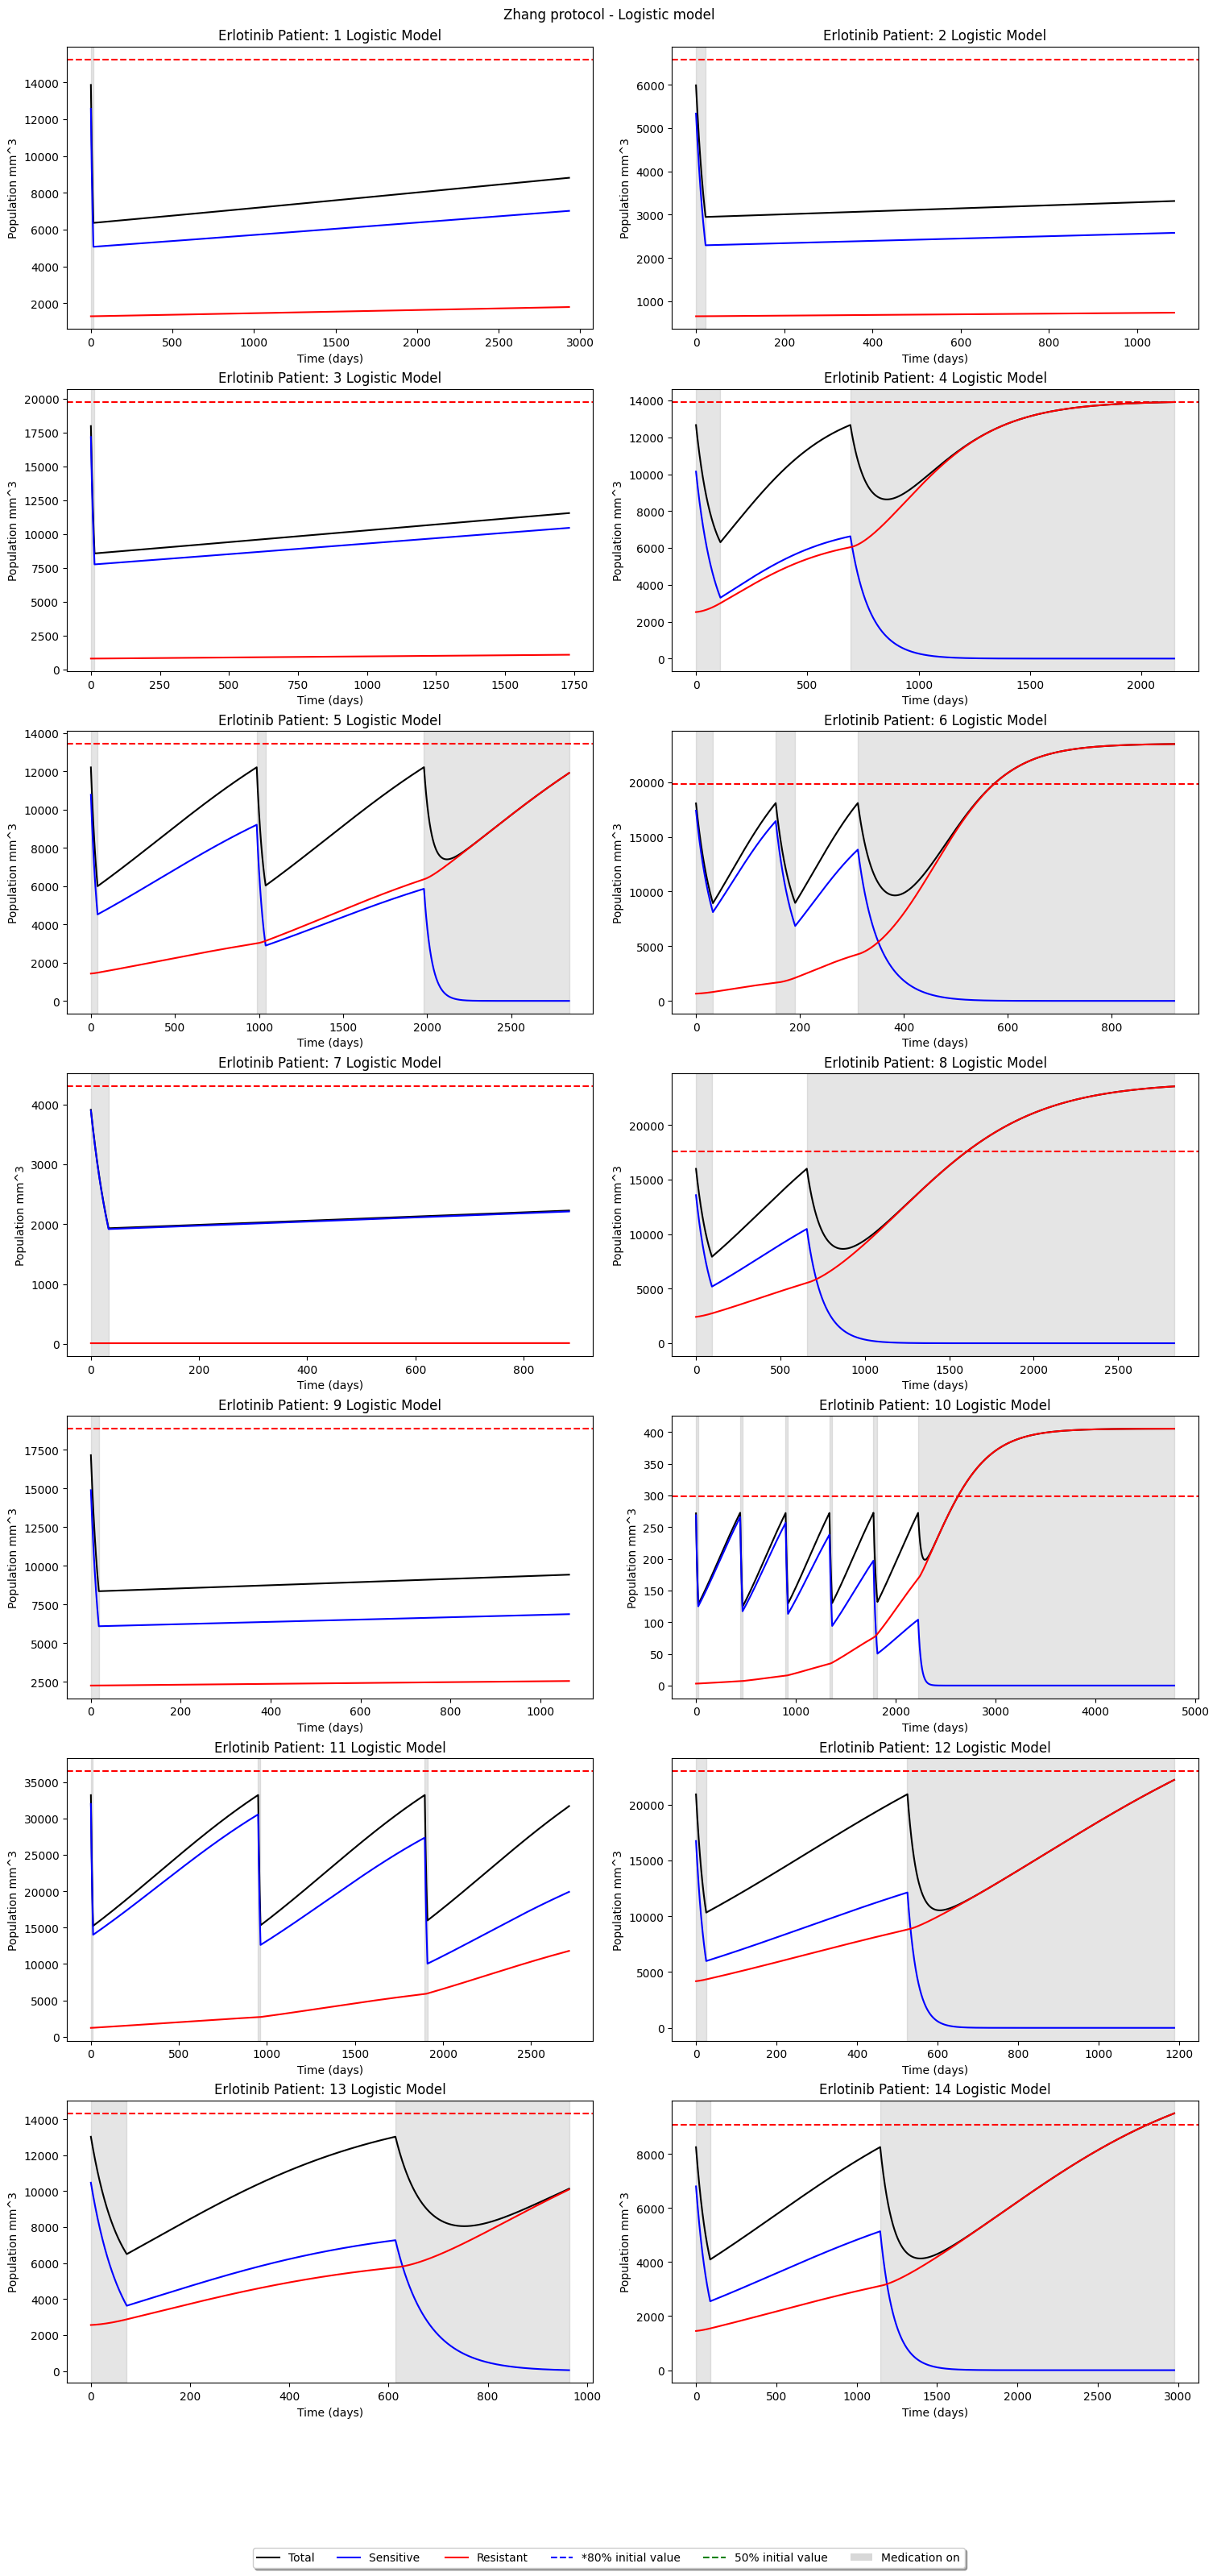

In [115]:
#### colour bars
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15,30), constrained_layout=True)
sim_time_factor = 4 ### how much to extend the time

master_dictionary_copy0 = copy.deepcopy(master_dictionary) # parameters for medication off
for key in master_dictionary_copy0:
    master_dictionary_copy0[key][2] *= 0 # simulate dose of 0

Med_on = master_dictionary
Med_off = master_dictionary_copy0

# fitting data, switching medication off and on
for index, id in enumerate(unique_IDs, start=0):
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    switch_off = 0.5*data[0] # switch off medication when tumor volume is half of initial volume
    switch_on = data[0] # switch on medication when tumor volume is 80% of initial volume
    tspan = np.linspace(0, sim_time_factor*days[-1], 3000)

    # Initialize with medication on
    optimal_params = Med_on[id]
    init_populations = [optimal_params[3],data[0]-optimal_params[3]]
    #init_populations = optimal_params[3:-1]

    # Initialize sum_pops_log
    sum_pops = np.zeros_like(tspan)
    sensitive_values = []
    resistant_values = []
    switch_points = [] # list of switches for plotting
    med_on = True
    switch_point = tspan[0]

    # Simulate with medication switching
    for i, t in enumerate(tspan[:-1]):
        # Solve for the next time step
        pred_data = solve_ivp(system_ode_logistic, [t, tspan[i+1]],
                                init_populations, dense_output=True,
                                args = tuple([optimal_params[:3]]))
        sum_pops[i] = np.sum(pred_data.sol(tspan[i]), axis=0)
        sensitive_values.append(pred_data.sol(tspan[i])[0])
        resistant_values.append(pred_data.sol(tspan[i])[1])

        # Calculate the slope
        if i > 0:
            slope = sum_pops[i] - sum_pops[i-1]

            # Switch medication off if conditions are met
            if sum_pops[i] <= switch_off and slope < 0:
                optimal_params = Med_off[id] 
                # If med_on was active, shade the region where it was on
                if med_on:
                    switch_points.append((switch_point, t))
                    med_on = False
                    switch_point = t       

            # Switch medication on if conditions are met
            elif sum_pops[i] >= switch_on and slope > 0:
                optimal_params = Med_on[id]
                if not med_on:
                    switch_point = t
                    med_on = True   

        # Update initial populations for the next time step
        init_populations = pred_data.sol(tspan[i+1])

    # Solve for the last time step
    pred_data = solve_ivp(system_ode_logistic, [tspan[-2], tspan[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops[-1] = np.sum(pred_data.sol(tspan[-1]), axis=0)
    if med_on:
        switch_points.append((switch_point, tspan[-1]))  

        # Print switch points for the current ID
    print(f'Switch points for patient {index +1}: {switch_points}')

    
    # Store sensitive and resistant values
    sensitive_values.append(pred_data.sol(tspan[-1])[0])
    resistant_values.append(pred_data.sol(tspan[-1])[1])

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    #ax.plot(days, data, 'kx', label='Measured Total') 
    #ax.axhline(y=0.5*data[0], color='g', linestyle='--') ### 50% line, switch off
    ax.axhline(y=1.1*data[0], color='r', linestyle='--') ### 80% line, switch on
    ax.plot(tspan, sum_pops, 'k-', label='Total') # plot logistic model
    ax.plot(tspan, sensitive_values, 'b-', label='Sensitive') # plot logistic model
    ax.plot(tspan, resistant_values, 'r-', label='Resistant') 

   # Shade regions for all switch points
    for sp in switch_points:
        ax.axvspan(sp[0], sp[1], color='grey', alpha=0.2)

    #set axis labels
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index +1} Logistic Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [
    #Line2D([0], [0], marker='x', color='k', label='Measurement', linestyle='None'),
    Line2D([0], [0], color='k', label='Total'),
    Line2D([0], [0], color='b', label='Sensitive '),
    Line2D([0], [0], color='r', label='Resistant'),
    Line2D([0], [0], color='b', linestyle='--', label='*80% initial value'),
    Line2D([0], [0], color='g', linestyle='--', label='50% initial value'),
    Patch(facecolor='grey', alpha=0.3, label='Medication on')  
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Zhang protocol - Logistic model')  
plt.show()


##### zhang vs MTD

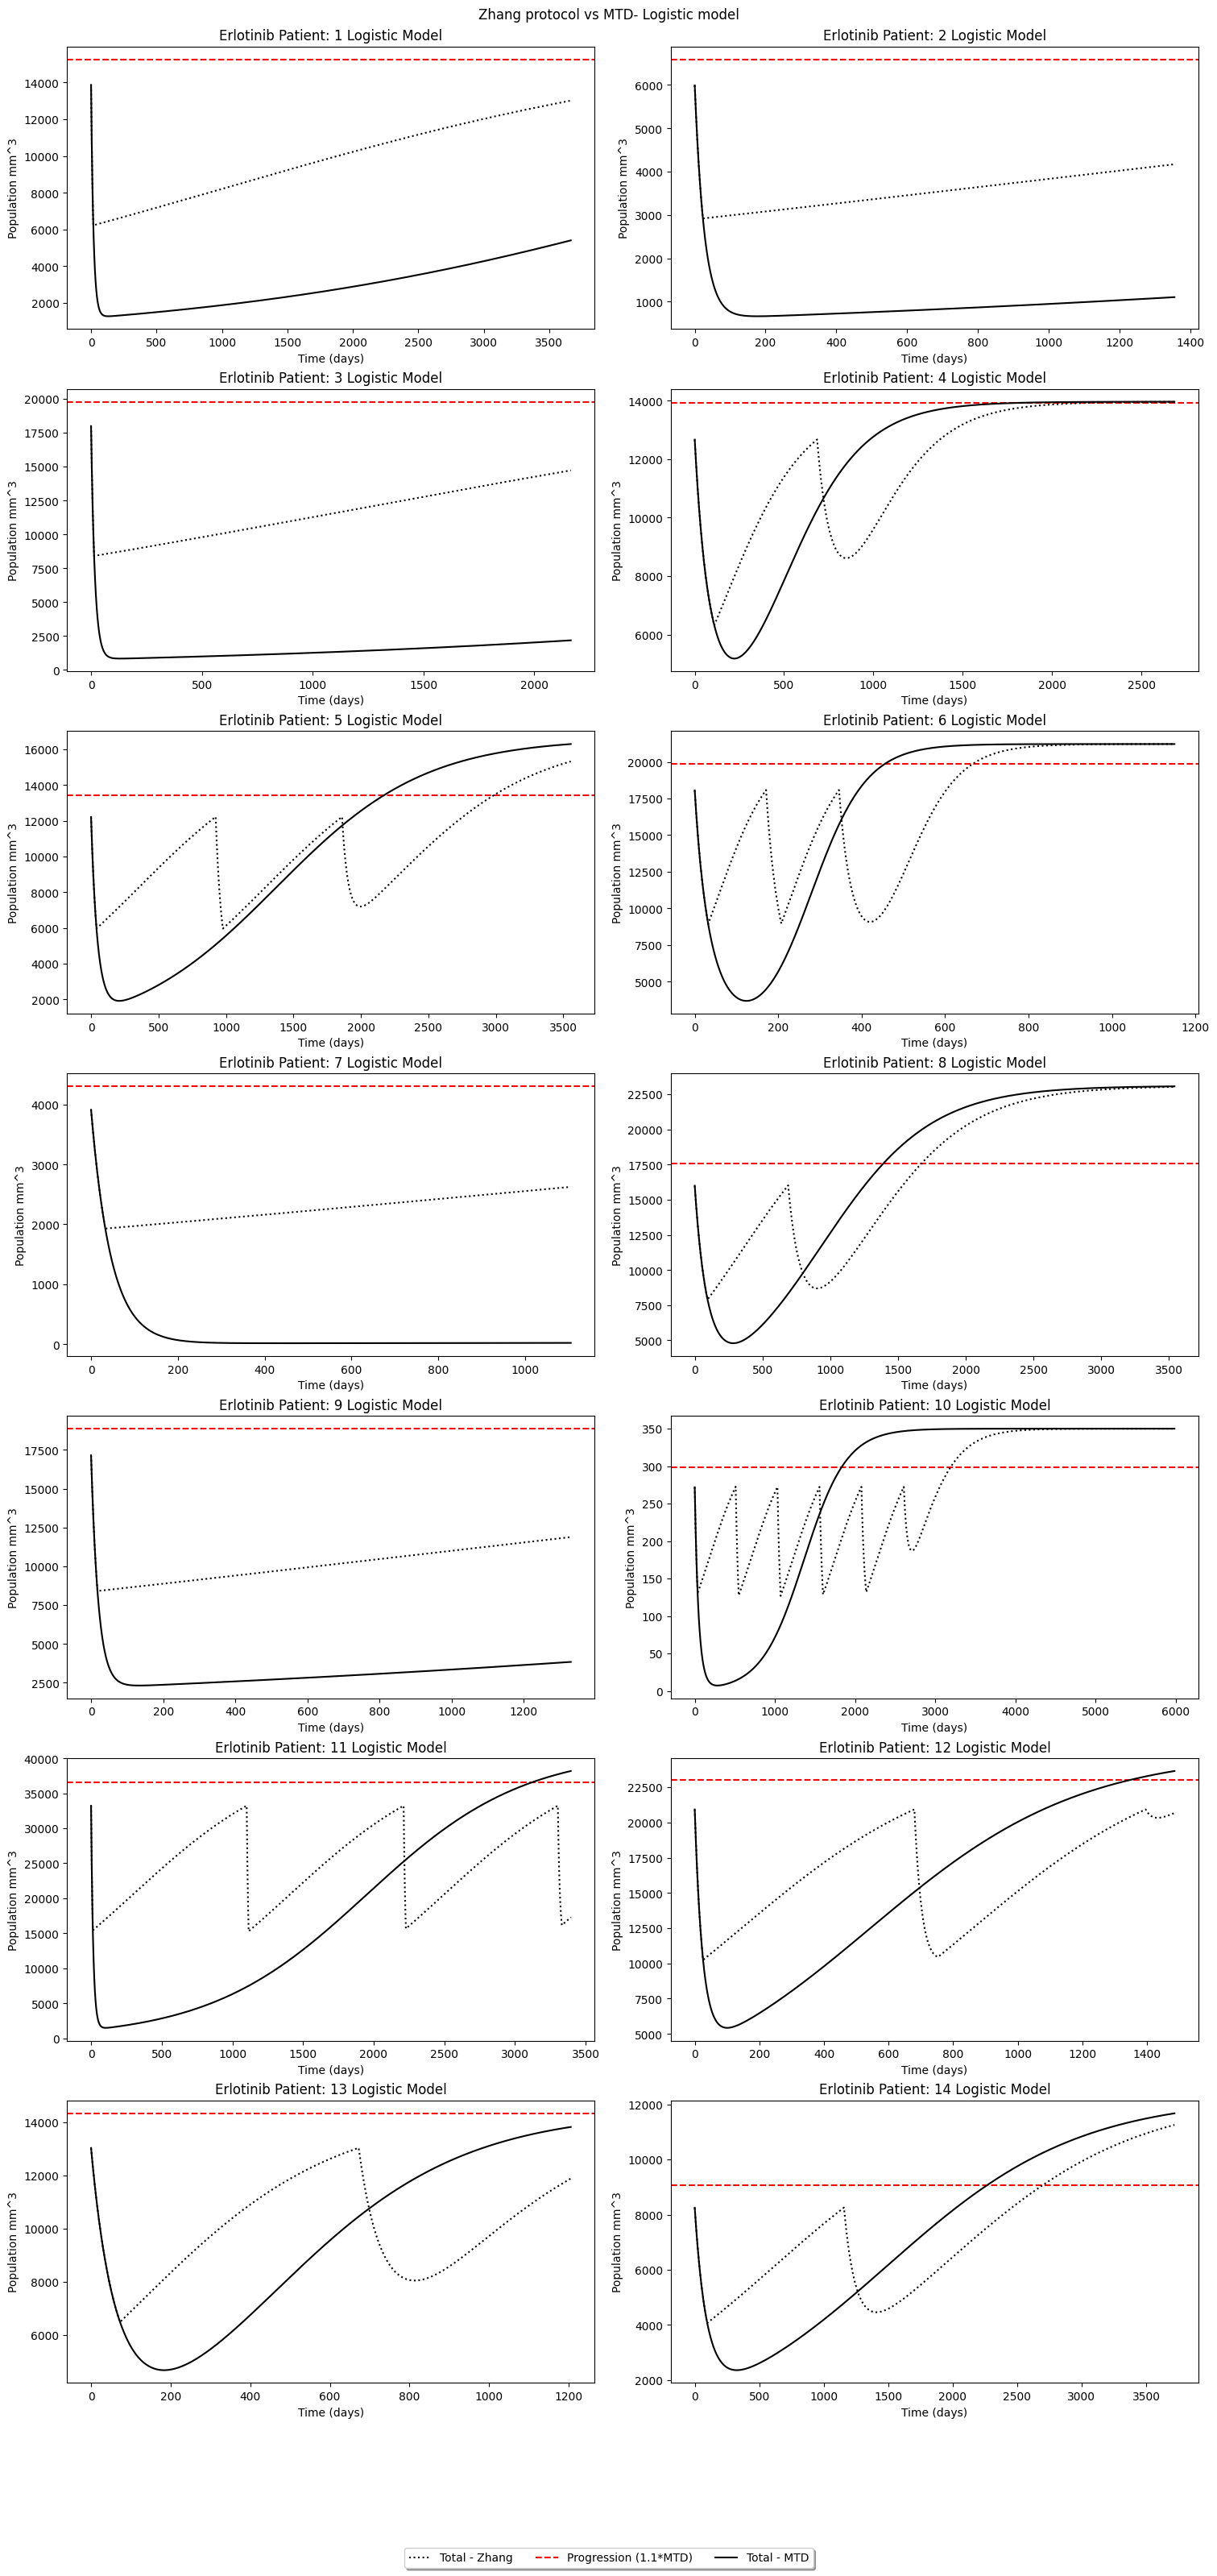

In [103]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15,30), constrained_layout=True)
sim_time_factor = 5 ### how much to extend the time

#### simulating Zhang protocol
master_dictionary_copy0 = copy.deepcopy(master_dictionary) # parameters for medication off
for key in master_dictionary_copy0:
    master_dictionary_copy0[key][2] *= 0 # simulate dose of 0

Med_on = master_dictionary
Med_off = master_dictionary_copy0

# fitting data, switching medication off and on
for index, id in enumerate(unique_IDs, start=0):
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    switch_off = 0.5*data[0] # switch off medication when tumor decreases to half of initial volume
    switch_on = data[0] # switch on medication when tumor increases to 80% of initial volume
    tspan = np.linspace(0, sim_time_factor*days[-1], 3000)

# simulate for MTD
    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3],data[0]-optimal_params_log[3]]
    pred_data_log = solve_ivp(system_ode_logistic, [0,sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

# simulate for Zhang protocol
    # Initialize with medication on
    optimal_params = Med_on[id]
    init_populations = [optimal_params[3],data[0]-optimal_params[3]]
    #init_populations = optimal_params[3:-1]

    # Initialize sum_pops_log
    sum_pops = np.zeros_like(tspan)
    sensitive_values = []
    resistant_values = []

    # Simulate with medication switching
    for i, t in enumerate(tspan[:-1]):
        # Solve for the next time step
        pred_data = solve_ivp(system_ode_logistic, [t, tspan[i+1]],
                                init_populations, dense_output=True,
                                args = tuple([optimal_params[:3]]))
        sum_pops[i] = np.sum(pred_data.sol(tspan[i]), axis=0)
        sensitive_values.append(pred_data.sol(tspan[i])[0])
        resistant_values.append(pred_data.sol(tspan[i])[1])
        # Calculate the slope
        if i > 0:
            slope = sum_pops[i] - sum_pops[i-1]
            # Switch medication off if conditions are met
            if sum_pops[i] <= switch_off and slope < 0:
                optimal_params = Med_off[id]
            # Switch medication on if conditions are met
            elif sum_pops[i] >= switch_on and slope > 0:
                optimal_params = Med_on[id]

        # Update initial populations for the next time step
        init_populations = pred_data.sol(tspan[i+1])

    # Solve for the last time step
    pred_data = solve_ivp(system_ode_logistic, [tspan[-2], tspan[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops[-1] = np.sum(pred_data.sol(tspan[-1]), axis=0)
    # Store sensitive and resistant values
    sensitive_values.append(pred_data.sol(tspan[-1])[0])
    resistant_values.append(pred_data.sol(tspan[-1])[1])



#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    #ax.plot(days, data, 'kx', label='Measured Total') 
    #ax.axhline(y=0.5*data[0], color='g', linestyle='--') ### 50% line, switch off
    #ax.axhline(y=data[0], color='b', linestyle='--') ###  switch on
    ax.axhline(y=1.1*data[0], color='r', linestyle='--') ### 110% line, progression
    ## plot MTD
    #ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b:', label='Sensitive - Log') 
    #ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r:', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ## plot Zhang protocol
    ax.plot(tspan, sum_pops, 'k:', label='Total') 
    #ax.plot(tspan, sensitive_values, 'b-', label='Sensitive') # 
    #ax.plot(tspan, resistant_values, 'r-', label='Resistant') 

    #set axis labels
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index + 1} Logistic Model') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [
    #Line2D([0], [0], marker='x', color='k', label='Measurement', linestyle='None'),
    Line2D([0], [0], color='k',linestyle=":", label='Total - Zhang'),
    #Line2D([0], [0], color='b', label='Sensitive - Zhang'),
    #Line2D([0], [0], color='r', label='Resistant - Zhang'),
    #Line2D([0], [0], color='b', linestyle='--', label='80% initial value'),
    #Line2D([0], [0], color='g', linestyle='--', label='50% initial value'),
    Line2D([0], [0], color='r', linestyle='--', label='Progression (1.1*MTD)'),
    Line2D([0], [0], color='k', linestyle='-', label='Total - MTD')
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Zhang protocol vs MTD- Logistic model')  
plt.show()

##### TTP Zhang

In [141]:
sim_time_factor = 12 ### longer simulation to give all time to progress
# Create a dictionary of lists to collect progression and competitive release times

unique_IDs = df.ID.unique()
lists = {'id': unique_IDs}
list_names = ['progression', 'progression_half', 'progression_02', 'progression_0', 'progression_zhang', 
              'comp_release', 'comp_release_half', 'comp_release_02', 'comp_release_zhang']
lists.update({name: [] for name in list_names})

# Store changed medication parameters
master_dictionary_copy = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5 # simulate dose of 0.5 MTD

master_dictionary_copy2 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy2:
    master_dictionary_copy2[key][2] *= 0.2 # simulate dose of 0.2 MTD

master_dictionary_copy0 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy0:
    master_dictionary_copy0[key][2] *= 0 # simulate dose of 0

master_dictionary_zhang = copy.deepcopy(master_dictionary)
for key in master_dictionary_zhang:
    master_dictionary_zhang[key][2] *= 0 # simulate dose of 0
   
# setting up subplots
for index, id in enumerate(unique_IDs, start=0):
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

### optimal params original medication 
    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3],data[0]-optimal_params_log[3]]
    pred_data_log = solve_ivp(system_ode_logistic, [0,sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

### optimal params 1/2 medication
    optimal_params_log_half = master_dictionary_copy[id] 
    init_populations_log_half = [optimal_params_log_half[3],data[0]-optimal_params_log_half[3]]

    pred_data_log_half = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_half, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_half[:3]]))
    sum_pops_log_half = np.sum(pred_data_log_half.sol(tspan), axis=0)

### optimal params 0.2 medication
    optimal_params_log_02 = master_dictionary_copy2[id] 
    init_populations_log_02 = [optimal_params_log_02[3],data[0]-optimal_params_log_02[3]]

    pred_data_log_02 = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_02, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_02[:3]]))
    sum_pops_log_02 = np.sum(pred_data_log_02.sol(tspan),    axis=0)

### optimal params 0 medication
    optimal_params_log_0 = master_dictionary_copy0[id]
    init_populations_log_0 = [optimal_params_log_0[3],data[0]-optimal_params_log_0[3]]

    pred_data_log_0 = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_0, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_0[:3]]))
    sum_pops_log_0 = np.sum(pred_data_log_0.sol(tspan), axis=0)

# optimal parameters zhang protocol
    Med_on = master_dictionary
    Med_off = master_dictionary_copy0

    for index, id in enumerate(unique_IDs, start=0):
        days = df.days[df.ID == id].tolist()
        data = df.Sum_tumor_volume[df.ID == id].tolist()
        switch_off = 0.5*data[0] # switch off medication when tumor volume is half of initial volume
        switch_on = data[0] # switch on medication when tumor volume is 80% of initial volume
        #tspan = np.linspace(0, sim_time_factor*days[-1], 3000)

    # Initialize with medication on
        optimal_params = Med_on[id]
        init_populations = [optimal_params[3],data[0]-optimal_params[3]]
    #init_populations = optimal_params[3:-1]

    # Initialize sum_pops_zhang
        sum_pops_z = np.zeros_like(tspan)
        sensitive_values = []
        resistant_values = []

        # Simulate with medication switching
        for i, t in enumerate(tspan[:-1]):
        # Solve for the next time step
            pred_data = solve_ivp(system_ode_logistic, [t, tspan[i+1]],
                                init_populations, dense_output=True,
                                args = tuple([optimal_params[:3]]))
            sum_pops[i] = np.sum(pred_data.sol(tspan[i]), axis=0)
            sensitive_values.append(pred_data.sol(tspan[i])[0])
            resistant_values.append(pred_data.sol(tspan[i])[1])

        # Calculate sign of slope
            if i > 0:
                slope = sum_pops_z[i] - sum_pops_z[i-1]

                if sum_pops_z[i] <= switch_off and slope < 0:
                    optimal_params = Med_off[id]

                elif sum_pops_z[i] >= switch_on and slope > 0:
                    optimal_params = Med_on[id]
        # Update initial populations for the next time step
            init_populations = pred_data.sol(tspan[i+1])

    # Solve for the last time step
    pred_data = solve_ivp(system_ode_logistic, [tspan[-2], tspan[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops_z[-1] = np.sum(pred_data.sol(tspan[-1]), axis=0)
    
    # Store sensitive and resistant values for Zhang protocol
    sensitive_values.append(pred_data.sol(tspan[-1])[0])
    resistant_values.append(pred_data.sol(tspan[-1])[1])            
                                          
# Find progression for logistic MTD
    progression_mtd = np.argmin(np.abs(sum_pops_log - 1.1*data[0]))
    x_value_progression = tspan[progression_mtd]
    lists['progression'].append(x_value_progression)

# Find progression for logistic half MTD
    progression_half_mtd = np.argmin(np.abs(sum_pops_log_half - 1.1*data[0]))
    x_value_progression_half = tspan[progression_half_mtd]
    #progression_half_list.append(x_value_progression_half)
    lists['progression_half'].append(x_value_progression_half)

# Find progression for logistic 0.2 MTD
    progression_02_mtd = np.argmin(np.abs(sum_pops_log_02 - 1.1*data[0]))
    x_value_progression_02 = tspan[progression_02_mtd]
    #progression_02_list.append(x_value_progression_02)
    lists['progression_02'].append(x_value_progression_02)  

# Find progression for logistic 0 MTD
    progression_0_mtd = np.argmin(np.abs(sum_pops_log_0 - 1.1*data[0]))
    x_value_progression_0 = tspan[progression_0_mtd]
    #progression_list_0.append(x_value_progression_0)
    lists['progression_0'].append(x_value_progression_0)    

# Find progression for logistic Zhang protocol
    progression_zhang = np.argmin(np.abs(sum_pops_z - 1.1*data[0]))
    x_value_progression_zhang = tspan[progression_zhang]
    #progression_list_zhang.append(x_value_progression_zhang)
    lists['progression_zhang'].append(x_value_progression_zhang)

# find time to competitive release MTD
    comp_rel_mtd = np.argmin(np.abs(pred_data_log.sol(tspan)[0]-pred_data_log.sol(tspan)[1]))
    x_val_cr_mtd = tspan[comp_rel_mtd]
    #comp_release_list.append(x_val_cr_mtd)
    lists['comp_release'].append(x_val_cr_mtd)

# find time to competitive release half MTD
    comp_rel_half = np.argmin(np.abs(pred_data_log_half.sol(tspan)[0]-pred_data_log_half.sol(tspan)[1]))
    x_val_cr_half = tspan[comp_rel_half]
    #comp_release_half_list.append(x_val_cr_half)
    lists['comp_release_half'].append(x_val_cr_half)

# find time to competitive release 0.2 MTD
    comp_rel_02 = np.argmin(np.abs(pred_data_log_02.sol(tspan)[0]-pred_data_log_02.sol(tspan)[1]))
    x_val_cr_02 = tspan[comp_rel_02]
    #comp_release_02_list.append(x_val_cr_02)
    lists['comp_release_02'].append(x_val_cr_02)

# find time to competitive release Zhang protocol
    comp_rel_zhang = np.argmin(np.abs(pred_data.sol(tspan)[0]-pred_data.sol(tspan)[1]))
    x_val_cr_zhang = tspan[comp_rel_zhang]
    #comp_release_list_zhang.append(x_val_cr_zhang)
    lists['comp_release_zhang'].append(x_val_cr_zhang)
    
# Combine lists into a DataFrame
df_all_progressions = pd.DataFrame(lists)
# adding event columns for survival analysis
for col in df_all_progressions.columns:
    new_col = col + '_event' if 'comp_release' not in col else col.replace('comp_release', 'cr_event')
  # 0 if event has not occured, 1 if it has
    df_all_progressions[new_col] = df_all_progressions[col].apply(lambda x: 0 if x == 0 else 1)

df_all_progressions

,id,progression,progression_half,progression_02,progression_0,progression_zhang,comp_release,comp_release_half,comp_release_02,comp_release_zhang,id_event,progression_event,progression_half_event,progression_02_event,progression_0_event,progression_zhang_event,cr_event,cr_event_half,cr_event_02,cr_event_zhang
0,A1002,8.804805,17.609610,44.024024,0.000000,8796.0,44.024024,79.243243,193.705706,0.000000,1,1,1,1,0,1,1,1,1,0
1,A1004,0.000000,0.000000,0.000000,3252.000000,3252.0,52.084084,107.423423,266.930931,572.924925,1,0,0,0,1,1,1,1,1,1
2,A1006,10.402402,26.006006,62.414414,0.000000,5196.0,52.012012,104.024024,260.060060,0.000000,1,1,1,1,0,1,1,1,1,0
3,A1007,574.090090,651.495495,477.333333,0.000000,6444.0,116.108108,232.216216,574.090090,0.000000,1,1,1,1,0,1,1,1,1,0
4,A1008,1614.162162,1656.864865,1784.972973,0.000000,8532.0,85.405405,179.351351,444.108108,0.000000,1,1,1,1,0,1,1,1,1,0
5,A1009,254.174174,96.696697,229.309309,0.000000,2760.0,110.510511,221.021021,552.552553,356.396396,1,1,1,1,0,1,1,1,1,1
6,A1011,0.000000,0.000000,0.000000,2652.000000,2652.0,270.774775,544.204204,1356.528529,262.810811,1,0,0,0,1,1,1,1,1,1
7,A1012,748.396396,790.918919,646.342342,0.000000,8496.0,136.072072,280.648649,697.369369,0.000000,1,1,1,1,0,1,1,1,1,0
8,A1013,15.975976,31.951952,79.879880,0.000000,3192.0,38.342342,76.684685,191.711712,559.159159,1,1,1,1,0,1,1,1,1,1
9,A1014,6268.972973,6714.702703,7059.783784,5636.324324,14364.0,158.162162,301.945946,762.054054,14349.621622,1,1,1,1,1,1,1,1,1,1


median time to progression MTD:  561.6096096096096
mean time to progression MTD:  1156.949806949807
median time to progression Half MTD:  374.5945945945946
mean time to progression Half MTD:  1165.9734019734021
median time to progression Zhang protocol:  6444.0
mean time to progression Zhang protocol:  6229.714285714285


Text(0.5, 1.0, 'Estimated time to progression MTD vs Zhang protocol - Logistic')

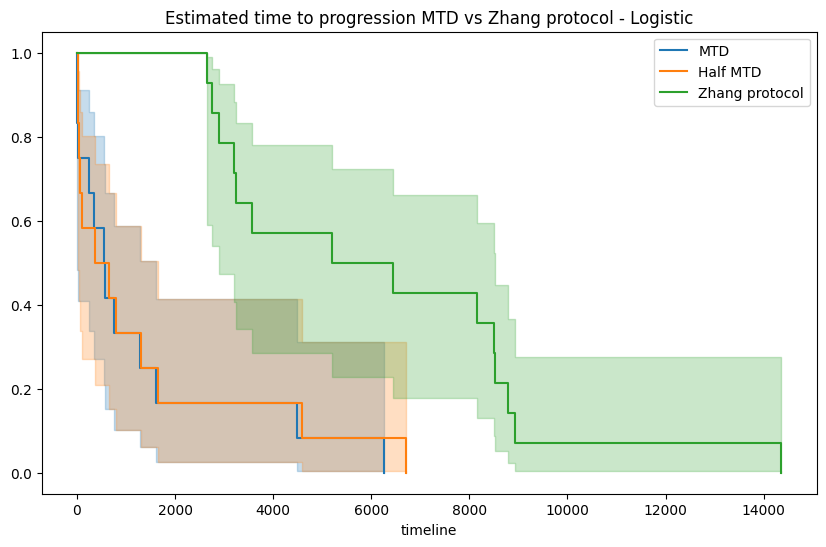

In [142]:
### survival plots for progression at 1.1*first data point 
Event1 = df_all_progressions["progression_event"]
Event2 = df_all_progressions["progression_half_event"]
Event3 = df_all_progressions["progression_02_event"]
Event4 = df_all_progressions["progression_0_event"]
Event5 = df_all_progressions["progression_zhang_event"]

# plotting progression
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6)) 

def plot_progression(column, event, label):
    kmf.fit(df_all_progressions[column], event, label=label)
    ax = kmf.plot_survival_function()
    print(f"median time to progression {label}: ", kmf.median_survival_time_)
    print(f"mean time to progression {label}: ", np.mean(df_all_progressions[column]))
    return ax

ax = plot_progression("progression", Event1, 'MTD')
ax = plot_progression("progression_half", Event2, 'Half MTD')
ax = plot_progression("progression_zhang", Event5, 'Zhang protocol')
ax.set_title("Estimated time to progression MTD vs Zhang protocol - Logistic")


median time to competitive release MTD: 86.84684684684684
mean time to competitive release MTD:  96.16645216645216
median time to competitive release 1/2 MTD:  179.35135135135135
median time to competitive release 0.2 MTD:  444.1081081081081
mean time to competitive release 0.2 MTD:  474.45817245817244
median time to competitive release Zhang protocol:  766.8468468468468
mean time to competitive release Zhang protocol:  1305.2046332046334


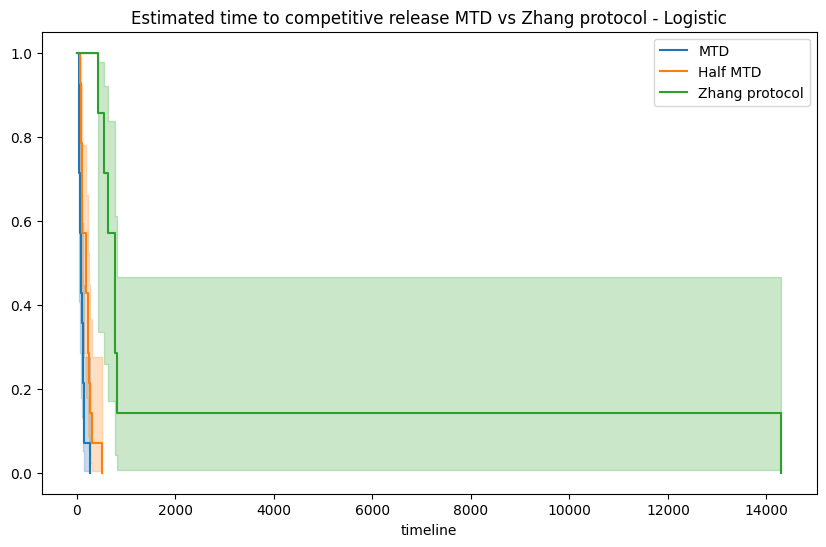

In [138]:
Event1 = df_all_progressions["cr_event"]
Event2 = df_all_progressions["cr_event_half"]
Event3 = df_all_progressions["cr_event_02"]
Event4 = df_all_progressions["cr_event_zhang"]

kmf = KaplanMeierFitter()
# Set the figure size
plt.figure(figsize=(10, 6))

# plot for MTD competitive release
kmf.fit(df_all_progressions["comp_release"],Event1, label='MTD')
ax = kmf.plot_survival_function()
print("median time to competitive release MTD:", kmf.median_survival_time_)
print("mean time to competitive release MTD: ",np.mean(df_all_progressions["comp_release"]))

# plot for 1/2 MTD competitive release
kmf.fit(df_all_progressions["comp_release_half"], Event2, label='Half MTD')
ax = kmf.plot_survival_function(ax=ax)
ax.set_title("Estimated time to competitive release MTD vs 0.5 MTD - Logistic")
print("median time to competitive release 1/2 MTD: ",kmf.median_survival_time_)

# plot for 0.2 MTD competitive release
kmf.fit(df_all_progressions["comp_release_02"], Event3, label='0.2 MTD')
#ax = kmf.plot_survival_function(ax=ax)
ax.set_title("Estimated time to competitive release MTD vs 0.2 MTD - Logistic")
print("median time to competitive release 0.2 MTD: ",kmf.median_survival_time_)
print("mean time to competitive release 0.2 MTD: ",np.mean(df_all_progressions["comp_release_02"]))

# plot for Zhang protocol competitive release
kmf.fit(df_all_progressions["comp_release_zhang"], Event4, label='Zhang protocol')
ax = kmf.plot_survival_function(ax=ax)
ax.set_title("Estimated time to competitive release MTD vs Zhang protocol - Logistic")
print("median time to competitive release Zhang protocol: ",kmf.median_survival_time_)
print("mean time to competitive release Zhang protocol: ",np.mean(df_all_progressions["comp_release_zhang"]))
# plot for 0.2 MTD competitive release
#kmf.fit(df_all_progressions["comp_release 0.2 MTD"], Event3, label='0.2 MTD')
#ax = kmf.plot_survival_function(ax=ax)
#print("median time to competitive release 0.2 MTD: ",kmf.median_survival_time_)
plt.show()


